In [1]:
import time

import numpy as np
import pyro
import pyro.contrib.examples.multi_mnist as multi_mnist
from pyro.infer import SVI, RenyiELBO, TraceGraph_ELBO
from pyro.optim import Adam
import pandas as pd

import torch
from pyro_air import AIR, make_prior, get_per_param_lr, count_accuracy, visualize_model

In [2]:
#####################
# Benchmark Configs
#####################
seed = 123456
use_cuda = torch.cuda.is_available()
batch_size = 64
num_epoches = 40

z_pres_prior = 0.01
learning_rate = 1e-4
baseline_lr = 1e-1
elbo = TraceGraph_ELBO()
# explicitly list out all configurable options
air_model_args = dict(
    num_steps=3,
    x_size=50,
    window_size=28,
    z_what_size=50,
    rnn_hidden_size=256,
    encoder_net=[200],
    decoder_net=[200],
    predict_net=[200],
    embed_net=None,
    bl_predict_net=[200],
    non_linearity="ReLU",
    decoder_output_bias=-2,
    decoder_output_use_sigmoid=True,
    use_masking=True,
    use_baselines=False,
    baseline_scalar=None,
    scale_prior_mean=3.0,
    scale_prior_sd=0.2,
    pos_prior_mean=0.0,
    pos_prior_sd=1.0,
    likelihood_sd=0.3,
    use_cuda=use_cuda,
)

In [3]:
#####################
# Initial Setup
#####################
device = torch.device("cuda" if use_cuda else "cpu")
z_pres_prior_fn = lambda t: [0.003, 2.7e-08, 2.43e-13][t]


X, Y = multi_mnist.load("data/air/.data")
X = (torch.from_numpy(X).float() / 255.0).to(device)
visualize_examples = X[5:10]
# Using float to allow comparison with values sampled from
# Bernoulli.
true_counts = torch.tensor([len(objs) for objs in Y], dtype=torch.float)

/home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch=0, current_epoch_step_time=36.95, loss=-468.33
accuracy=0.22609999775886536, counts=tensor([[11597,  5812,  1953,   586],
        [ 3669,  1774,   874, 13703],
        [  947,   331,   195, 18559]])


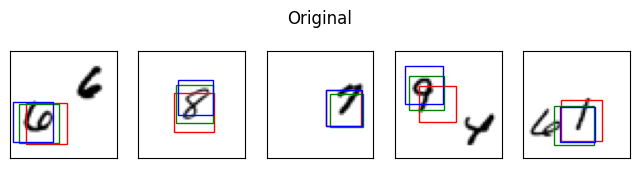

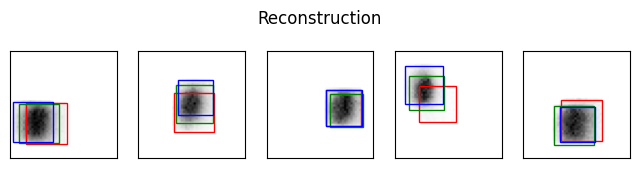

Epoch=1, current_epoch_step_time=37.65, loss=-508.88
Epoch=2, current_epoch_step_time=37.18, loss=-532.58
Epoch=3, current_epoch_step_time=35.93, loss=-547.03
Epoch=4, current_epoch_step_time=36.09, loss=-554.89
Epoch=5, current_epoch_step_time=35.90, loss=-560.89
accuracy=0.35321667790412903, counts=tensor([[17742,  2184,    22,     0],
        [ 1261,  3206,  2294, 13259],
        [   19,   243,   245, 19525]])


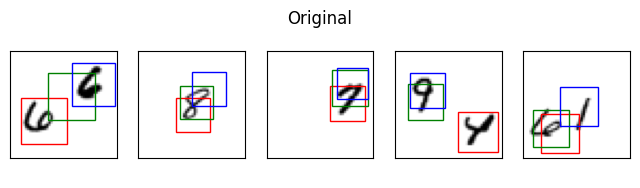

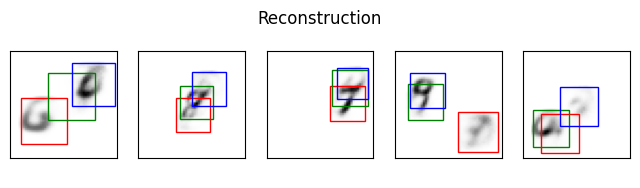

Epoch=6, current_epoch_step_time=36.62, loss=-565.88
Epoch=7, current_epoch_step_time=35.84, loss=-569.30
Epoch=8, current_epoch_step_time=36.05, loss=-573.08
Epoch=9, current_epoch_step_time=36.21, loss=-574.87
Epoch=10, current_epoch_step_time=36.12, loss=-578.34
accuracy=0.42108333110809326, counts=tensor([[17227,  2696,    25,     0],
        [  444,  6218,  4653,  8705],
        [    1,   891,  1820, 17320]])


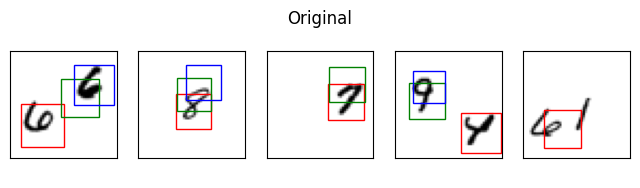

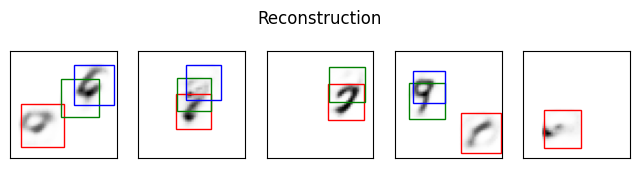

Epoch=11, current_epoch_step_time=36.77, loss=-579.48
Epoch=12, current_epoch_step_time=36.18, loss=-580.98
Epoch=13, current_epoch_step_time=35.94, loss=-583.51
Epoch=14, current_epoch_step_time=36.77, loss=-587.85
Epoch=15, current_epoch_step_time=35.75, loss=-588.12
accuracy=0.7133333086967468, counts=tensor([[19543,   405,     0,     0],
        [  764, 15093,  2416,  1747],
        [    4,  6238,  8164,  5626]])


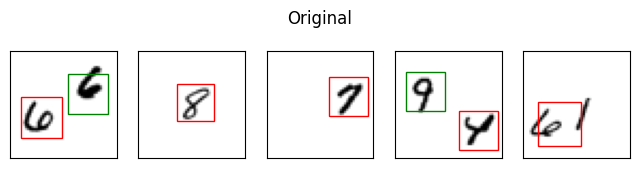

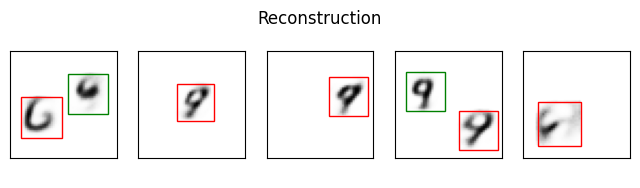

Epoch=16, current_epoch_step_time=36.05, loss=-591.42
Epoch=17, current_epoch_step_time=37.60, loss=-589.57
Epoch=18, current_epoch_step_time=36.82, loss=-591.69
Epoch=19, current_epoch_step_time=36.41, loss=-595.57
Epoch=20, current_epoch_step_time=36.41, loss=-595.56
accuracy=0.7189000248908997, counts=tensor([[19762,   186,     0,     0],
        [  308, 13545,  4089,  2078],
        [    0,  2939,  9827,  7266]])


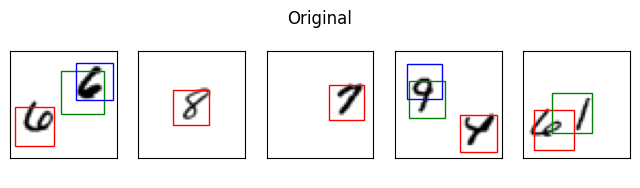

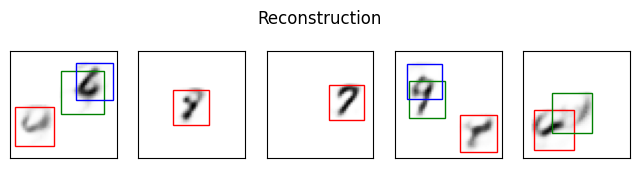

Epoch=21, current_epoch_step_time=39.65, loss=-597.17
Epoch=22, current_epoch_step_time=37.21, loss=-599.87
Epoch=23, current_epoch_step_time=36.98, loss=-601.77
Epoch=24, current_epoch_step_time=39.62, loss=-604.17
Epoch=25, current_epoch_step_time=39.81, loss=-606.64
accuracy=0.8745833039283752, counts=tensor([[19714,   234,     0,     0],
        [  127, 14655,  5159,    79],
        [    0,  1393, 18106,   533]])


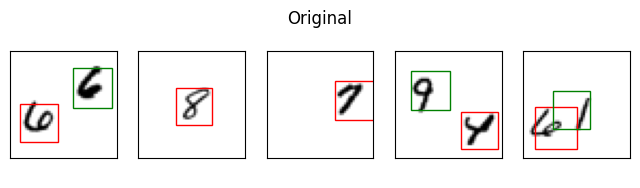

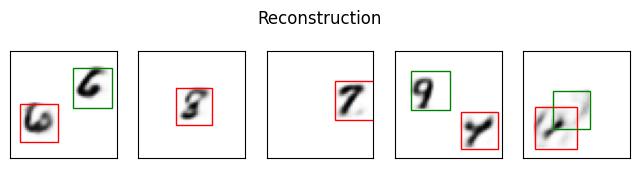

Epoch=26, current_epoch_step_time=39.35, loss=-603.90
Epoch=27, current_epoch_step_time=39.64, loss=-608.00
Epoch=28, current_epoch_step_time=39.09, loss=-608.48
Epoch=29, current_epoch_step_time=36.99, loss=-609.92
Epoch=30, current_epoch_step_time=37.60, loss=-611.75
accuracy=0.8765833377838135, counts=tensor([[19843,   105,     0,     0],
        [  156, 16046,  3815,     3],
        [    0,  3155, 16706,   171]])


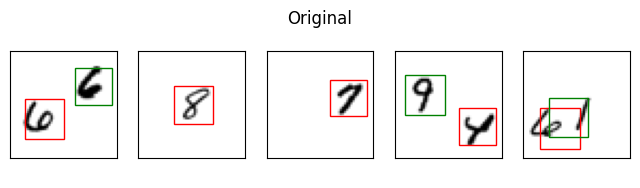

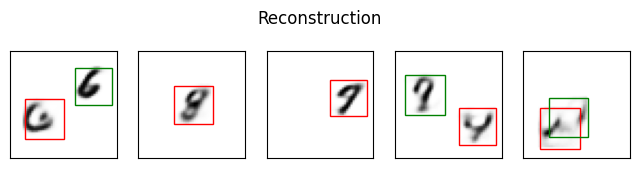

Epoch=31, current_epoch_step_time=39.06, loss=-612.25
Epoch=32, current_epoch_step_time=38.30, loss=-613.72
Epoch=33, current_epoch_step_time=36.13, loss=-614.15
Epoch=34, current_epoch_step_time=37.81, loss=-615.63
Epoch=35, current_epoch_step_time=36.10, loss=-616.10
accuracy=0.901283323764801, counts=tensor([[19885,    63,     0,     0],
        [  184, 16600,  3235,     1],
        [    0,  2359, 17592,    81]])


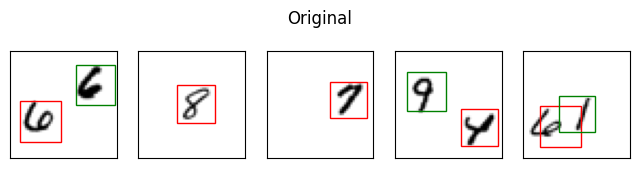

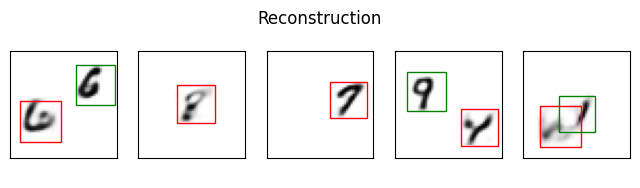

Epoch=36, current_epoch_step_time=35.40, loss=-615.53
Epoch=37, current_epoch_step_time=36.36, loss=-616.66
Epoch=38, current_epoch_step_time=37.16, loss=-616.49
Epoch=39, current_epoch_step_time=36.10, loss=-617.87


In [4]:
if seed is not None:
    pyro.set_rng_seed(seed)
pyro.distributions.enable_validation(False)
pyro.clear_param_store()  # just in case

air = AIR(**air_model_args)
adam = Adam(get_per_param_lr(learning_rate, baseline_lr))
svi = SVI(air.model, air.guide, adam, loss=elbo)

all_loss = []
all_accuracy = []
time_per_epoch = []

for i in range(num_epoches):
    start_time = time.perf_counter()
    # technically this might step over slightly more than 1 epoch...
    losses = []
    for j in range(int(np.ceil(X.size(0) / batch_size))):
        losses.append(
            svi.step(X, batch_size=batch_size, z_pres_prior_p=z_pres_prior_fn)
        )
    end_time = time.perf_counter()

    accuracy, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)

    all_loss.append(np.mean(losses) / X.size(0))
    all_accuracy.append(accuracy)
    time_per_epoch.append(end_time - start_time)

    print(
        f"Epoch={i}, current_epoch_step_time={time_per_epoch[-1]:.2f}, loss={all_loss[-1]:.2f}"
    )
    if i % 5 == 0:
        print(f"accuracy={accuracy}, counts={counts}")
        visualize_model(visualize_examples, air)

In [6]:
wall_clock_times = np.cumsum(time_per_epoch)
arr = np.array([all_loss, all_accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/pyro_reinforce_epochs_40_mccoy_prior.csv", index=False)